<a href="https://colab.research.google.com/github/jahnavi-maddhuri/JahnaviMaddhuri-DukeXAI/blob/main/ExplainableDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning

#### Jahnavi Maddhuri

In [1]:
# downloads
!pip install -U tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.7 MB/s eta 0:00:00


In [2]:
# import libraries

import kagglehub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils import normalize
from tf_keras_vis.scorecam import Scorecam

## Dataset and Model Inspiration
I came accross a kaggle notebook by Chandana Kuntala where they predict what the state of the traffic light is based on an image. They implemented and ImageNet model as well as InceptionV3 which is Google's pretrained model. Their notebook is linked [here](https://www.kaggle.com/code/venkatkumar001/trafficlight-detection-classification-tf).

### Dataset
For this assignment, I chose the Lisa Traffic Light dataset available through kaggle ([Kaggle Link](https://www.kaggle.com/datasets/mbornoe/lisa-traffic-light-dataset)). This dataset has 43k frames total with 113k annotated traffic lights across all the images. The frames are taken from video footage of these traffic lights and include both day time and night time frames. For the purposes of my analysis, I only use Day Clip 1 and randomize data into train/validation split. I use an 80/20 split, fit and validate the model.


In [3]:
path = kagglehub.dataset_download("mbornoe/lisa-traffic-light-dataset")


Using Colab cache for faster access to the 'lisa-traffic-light-dataset' dataset.


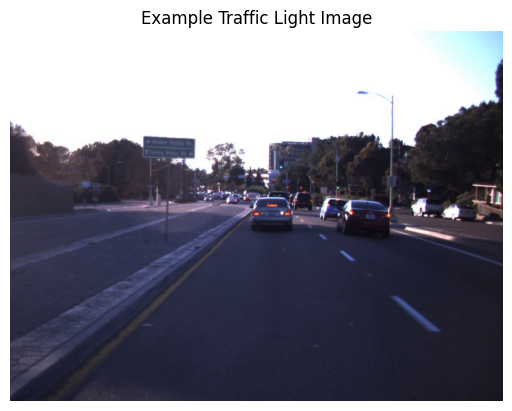

In [4]:
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        'dayClip1--00000.jpg')

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.title('Example Traffic Light Image')
plt.show()


In [5]:
# Load Y labels
dayclip1 = pd.read_csv(os.path.join(path, 'Annotations', 'Annotations',
                                    'dayTrain', 'dayClip1',
                                    'frameAnnotationsBULB.csv'), sep=';')

# Create y_map df
y_map = dayclip1[['Filename', 'Annotation tag']]
y_map = y_map.drop_duplicates().copy()
y_map.reset_index(drop=True, inplace=True)
y_map['Filename'] = y_map['Filename'].str.split('/').str[-1]

y_map.head()

,Filename,Annotation tag
0,dayClip1--00000.jpg,go
1,dayClip1--00001.jpg,go
2,dayClip1--00002.jpg,go
3,dayClip1--00003.jpg,go
4,dayClip1--00004.jpg,go


In [6]:
# train/val split
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

images_dir = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames')

y_map["Filename"] = y_map["Filename"].astype(str)
y_map["Annotation tag"] = y_map["Annotation tag"].astype(str)

train_df, val_df = train_test_split(
    y_map, test_size=0.2, stratify=y_map["Annotation tag"], random_state=0
)
print('Distribution of Annotation tag in Training df:')
print(train_df["Annotation tag"].value_counts(), "\n")
print('In Validation df:')
print(val_df["Annotation tag"].value_counts(), "\n")

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

Distribution of Annotation tag in Training df:
Annotation tag
stop    1081
go       739
Name: count, dtype: int64 

In Validation df:
Annotation tag
stop    271
go      185
Name: count, dtype: int64 



In [7]:
# Convert to tf for InceptionV3
train_flow = train_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=images_dir,
    x_col="Filename",
    y_col="Annotation tag",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=0
)

val_flow = val_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=images_dir,
    x_col="Filename",
    y_col="Annotation tag",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)



Found 1820 validated image filenames belonging to 2 classes.
Found 456 validated image filenames belonging to 2 classes.


In [8]:
# Instantiate and train InceptionV3 model
base = InceptionV3(input_shape=IMAGE_SIZE + (3,),
                   weights="imagenet", include_top=False)
for layer in base.layers:
    layer.trainable = False

x = Flatten()(base.output)
num_classes = 2
out = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base.input, outputs=out)
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])


history = model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=2,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 348s 6s/step - accuracy: 0.8594 - loss: 1.1638 - val_accuracy: 0.8421 - val_loss: 1.4357
Epoch 2/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 6s/step - accuracy: 0.8969 - loss: 1.2167 - val_accuracy: 0.9232 - val_loss: 0.5162


In [9]:
# Model Results

train_loss, train_acc = history.history['loss'][-1], history.history['accuracy'][-1]
val_loss, val_acc = history.history['val_loss'][-1], history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_acc:.3f}")
print(f"Final Validation Accuracy: {val_acc:.3f}")
print(f"Final Training Loss: {train_loss:.3f}")
print(f"Final Validation Loss: {val_loss:.3f}")


Final Training Accuracy: 0.914
Final Validation Accuracy: 0.923
Final Training Loss: 0.961
Final Validation Loss: 0.516


### GradCAM vs GradCAM++ vs ScoreCAM

In [32]:
def gradCAM_variation(img, model):
  '''Generates heatmap objects to explain prediction of img.
  Implements GradCAM, GradCAM++ and SearchCAM'''

  pred_idx = int(np.argmax(model.predict(img), axis=1)[0])
  prediction = {v:k for k,v in val_flow.class_indices.items()}[pred_idx]
  score = CategoricalScore([pred_idx])
  penultimate = 'mixed10'

  gc = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
  gcpp = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)
  sc = Scorecam(model, model_modifier=ReplaceToLinear(), clone=True)

  cam = normalize(gc(score, img, penultimate_layer=penultimate)[0])
  cam_pp = normalize(gcpp(score, img, penultimate_layer=penultimate)[0])
  cam_sc = sc(score, img, penultimate_layer='mixed10')[0]

  return cam, cam_pp, cam_sc, prediction

In [33]:
def plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no):
  '''plot raw img along with heatmaps from gradCAM variations'''
  # 2x3 grid plot
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  for ax in axes.flat:
      ax.axis('off')

  # (top, center) -> raw image
  axes[0, 1].imshow(img_im)
  axes[0, 1].axis("off")
  axes[0, 1].set_title(f'Traffic Light Image {img_no}')

  # (bottow, left) -> GradCAM
  axes[1, 0].imshow(cam, cmap='jet')
  axes[1, 0].set_title('GradCAM')

  # (bottom, center) -> GradCAM++
  axes[1, 1].imshow(cam_pp, cmap='jet')
  axes[1, 1].set_title('GradCAM++')

  # (bottom, right) -> ScoreCAM
  axes[1, 2].imshow(cam_sc, cmap='jet')
  axes[1, 2].set_title('ScoreCAM')

  plt.tight_layout()
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 224, 224, 3))',)
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step


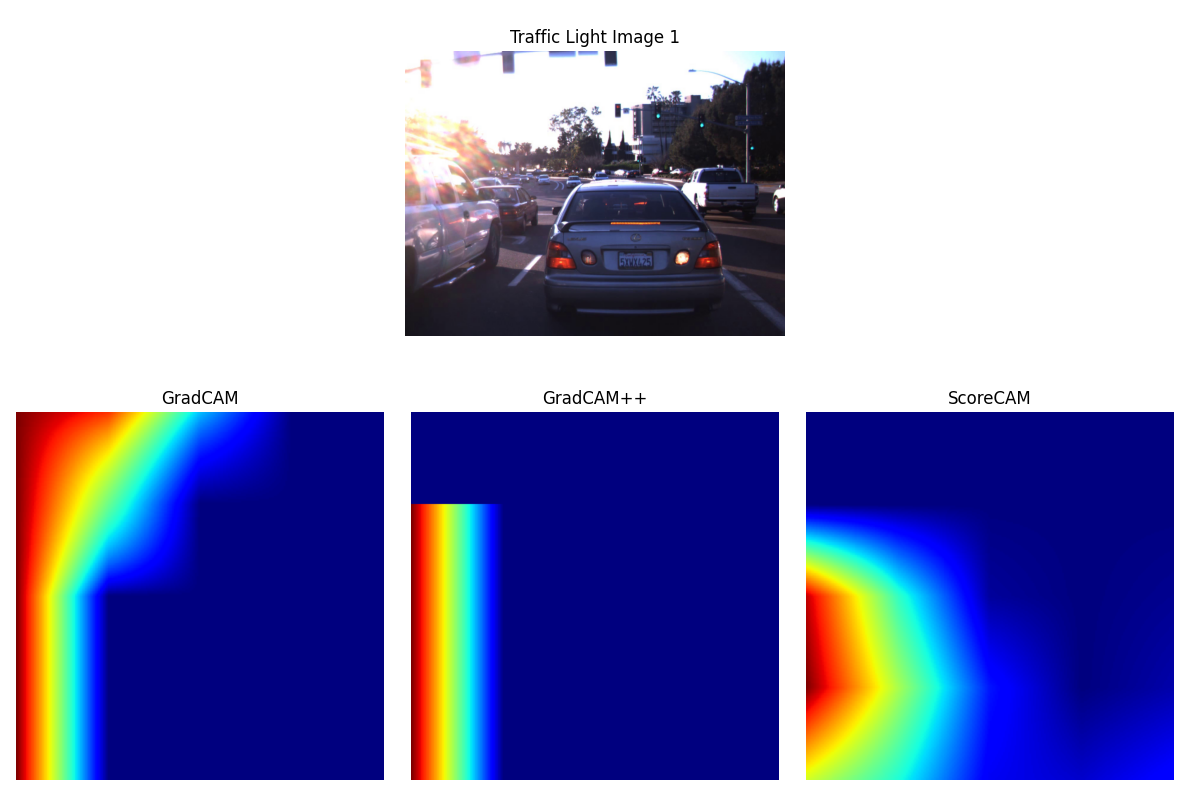

Prediction: go
True Label: go


In [34]:
# pull data for image 1
val_flow.reset()

imgs, labels = next(iter(val_flow))
img = imgs[0:1]

cam, cam_pp, cam_sc, prediction = gradCAM_variation(img, model)

# get image
i = 0
img_no = i+1
clip_str = val_df.reset_index(drop=True).loc[i]['Filename']
true = val_df.reset_index(drop=True).loc[i]['Annotation tag']
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        clip_str)
img_im = mpimg.imread(img_path)

plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no)

print(f"Prediction: {prediction}")
print(f"True Label: {true}")

### **Image 1 Comparison**
Each method, Grad-CAM, Grad-CAM++ and ScoreCAM produce heatmap explanations to highlight what parts of the image that correlated with the prediction for Traffic Image 1, **go**. In general, Grad-CAM is a faster algorithem that can quickly reach a baseline. It focuses on highlighting where gradients say the 'go' class is most supported. Grad-CAM++ also uses the gradients, but is sharper and better captures multiple instances. Finally, Score-CAM is different in that it is not based on the gradients. It uses activation maps instead, but can be biased to strong brightness in the image.

In Image 1, Grad-CAM, Grad-CAM++ and Score-CAM all show a deep red and yellow color near the glare from the sun on the left hand side of the image. Red and yellow indicate regions of the image that most positively contribute to "go". However none of the images used the traffic light in the upper right hand side of the image for classification. This suggests that if this same traffic light were red, the model would still predict this light to be "go" incorrectly.

One interesting difference in the three heatmaps is that Grad-CAM highlights the entire left hand corner where the sun is bright. However, Grad-CAM++ and Score-CAM both highlight more of the bottom left edge. I wonder if they are picking up on the reflection of the glare on the white/silver car.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 224, 224, 3))',)
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


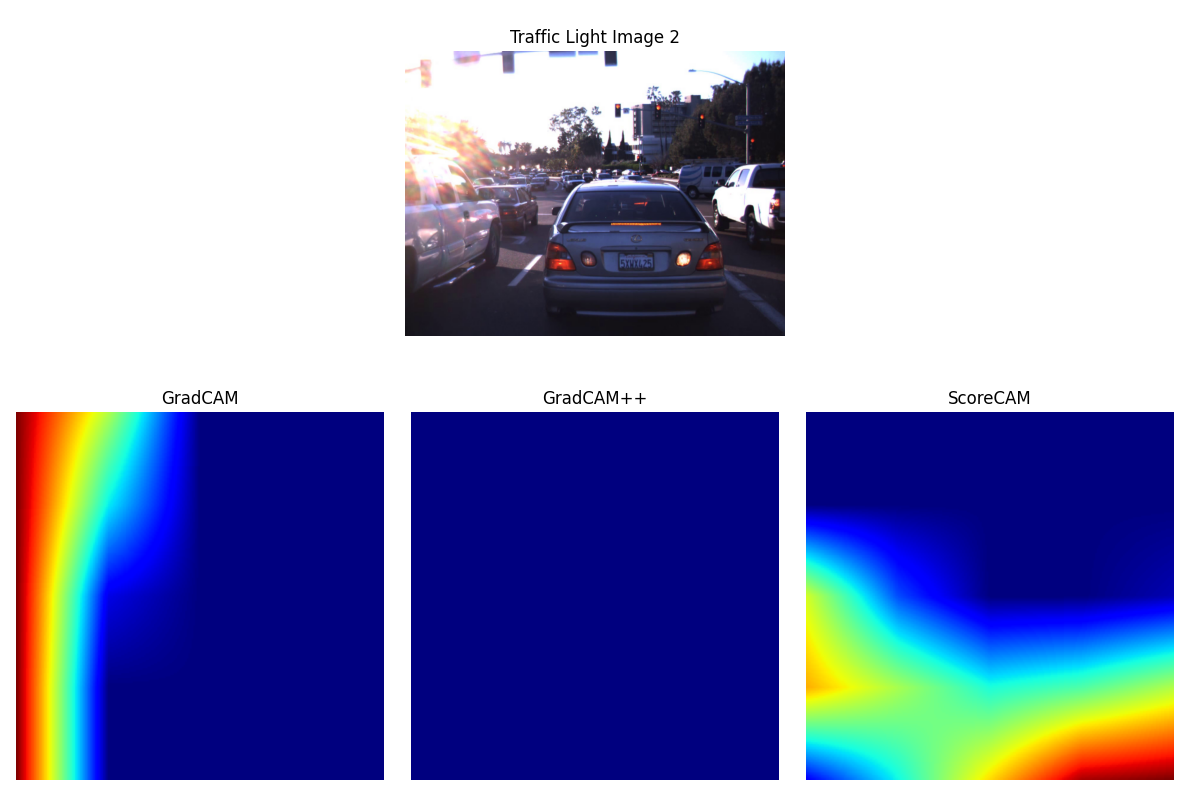

Prediction: go
True Label: stop


In [35]:
# pull data for image 2

imgs, labels = next(iter(val_flow))
img = imgs[0:1]

cam, cam_pp, cam_sc, prediction = gradCAM_variation(img, model)

# get image
i = i+1
img_no = i+1
clip_str = val_df.reset_index(drop=True).loc[i]['Filename']
true = val_df.reset_index(drop=True).loc[i]['Annotation tag']
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        clip_str)
img_im = mpimg.imread(img_path)

plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no)

print(f"Prediction: {prediction}")
print(f"True Label: {true}")

#### **Image 2 Comparison**
For Image 2, Grad-CAM shows similar behavior as that for Image 1. Still, the model is picking up on the glare from the sun as large evidence for why the traffic light was predicted as "go." Next, GradCAM++ did not pick up on any strong positive indications that this image should be predicted as "go." Finally, Score-CAM picks up on the bottom right cornder of the frame. This is interesting because there is not much light in the bottom right edge of the frame. Score-CAM also highlights a bit of the glare from the sun. The fact that Score-CAM and Grad-CAM highlight different areas for the most positive contribution towards the "go" prediction indicates there may be other factors than the traffic light itself impacting this prediction.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(32, 224, 224, 3))',)
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step


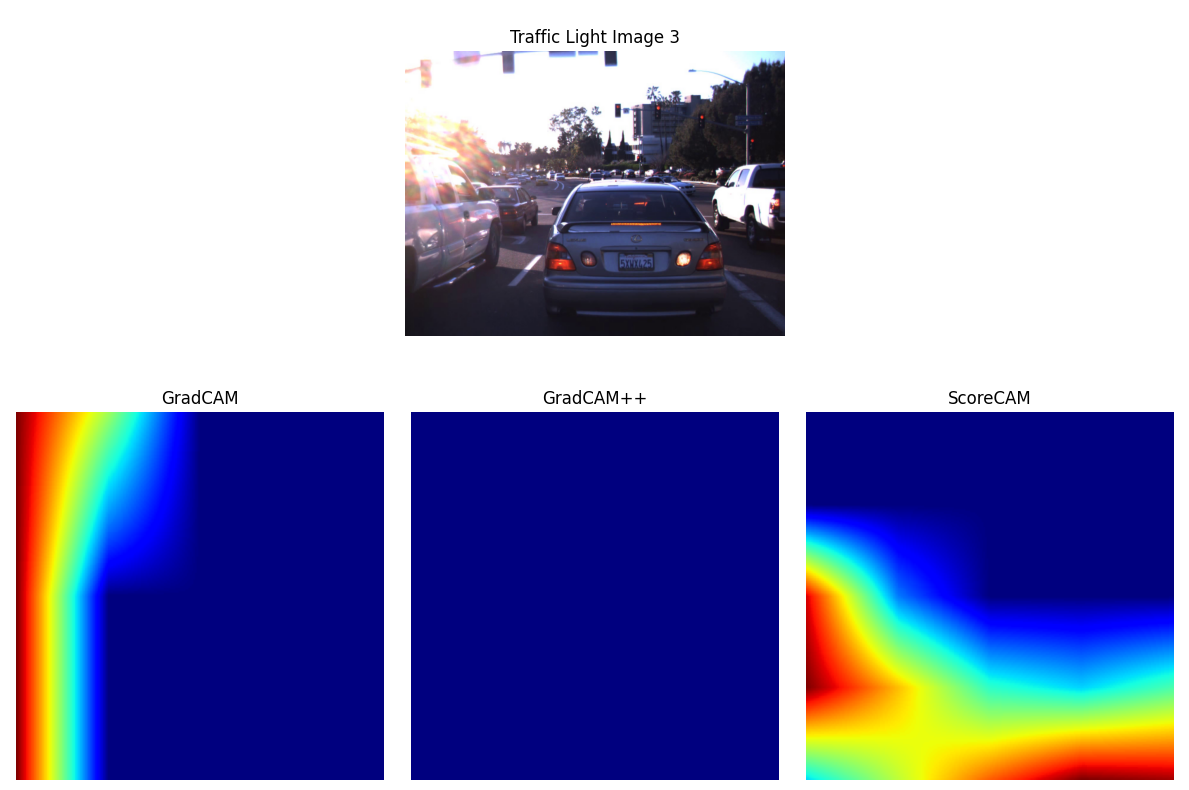

Prediction: go
True Label: stop


In [36]:
# pull data for image 3
imgs, labels = next(iter(val_flow))
img = imgs[0:1]

cam, cam_pp, cam_sc, prediction = gradCAM_variation(img, model)

# get image
i = i+1
img_no = i+1
clip_str = val_df.reset_index(drop=True).loc[i]['Filename']
true = val_df.reset_index(drop=True).loc[i]['Annotation tag']
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        clip_str)
img_im = mpimg.imread(img_path)

plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no)

print(f"Prediction: {prediction}")
print(f"True Label: {true}")

#### **Image 3 Comparison**
Since Image 3 is almost identical to Image 2, we see a lot of similarities in this the outputs from Grad-CAM, Grad-CAM++ and Score-CAM. This indicates consistensy in the model's behavior as even the predicted class did not change from "go." There appears to be evidence that when there is a glare, the model predicts class as "go." One difference is that Score-CAM has more evidence pointing towards "go" this time. There is more deep red from the glare in the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


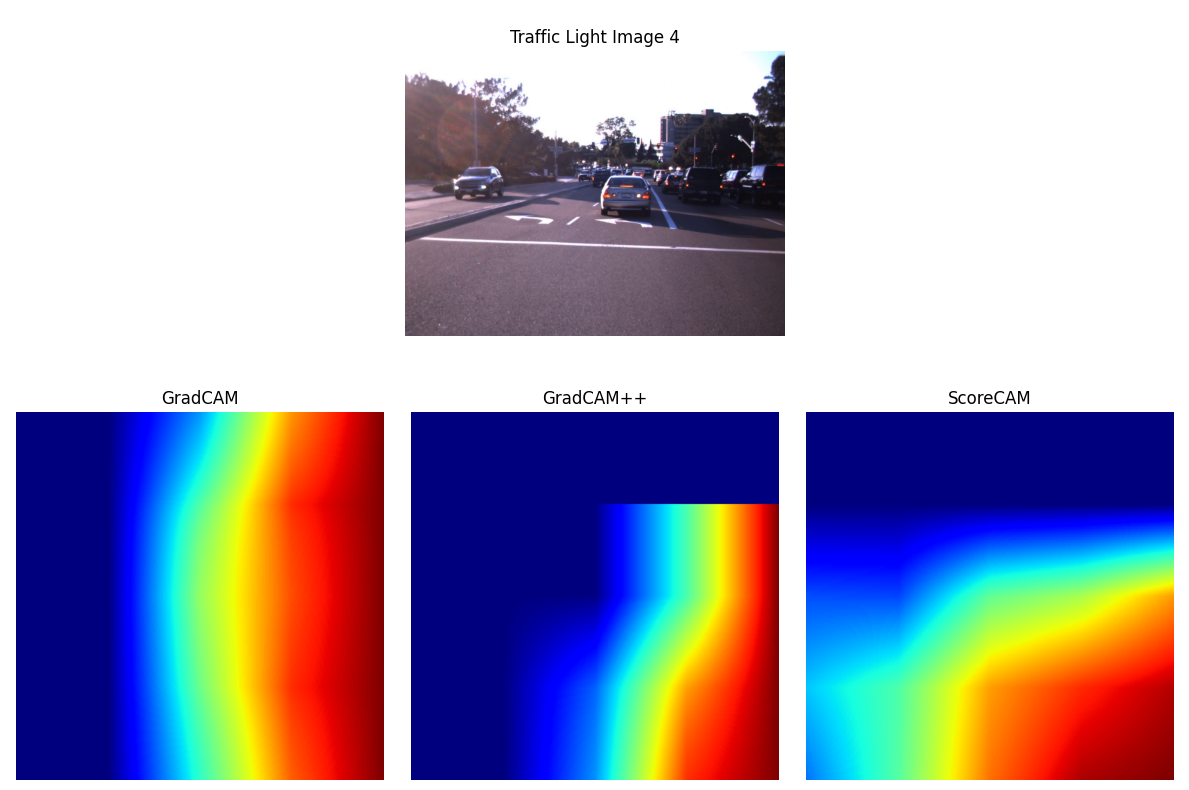

Prediction: stop
True Label: go


In [37]:
# pull data for image 4
imgs, labels = next(iter(val_flow))
img = imgs[0:1]

cam, cam_pp, cam_sc, prediction = gradCAM_variation(img, model)

# get image
i = i+1
img_no = i+1
clip_str = val_df.reset_index(drop=True).loc[i]['Filename']
true = val_df.reset_index(drop=True).loc[i]['Annotation tag']
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        clip_str)
img_im = mpimg.imread(img_path)

plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no)

print(f"Prediction: {prediction}")
print(f"True Label: {true}")

#### **Image 4 Comparison**
This prediction was correct, but the areas of the image highlighted by Grad-CAM, Grad-CAM++ and Score-CAM, do not provide me confidence in the model. Grad-CAM sees the most positive contribution towards the "stop" prediction from the right edge of the image. On this side of the image, there are many small red lights that could be classified as the red traffic light since the light is so far. In Grad-CAM++, the bottom right edge is highlighted, but in this part of the image there is a shadow from the sun - no reason to predict a red stoplight. Finally, Score-CAM also highlights the bottom left of the image, but this. The lack of strong correlations between the highlighted positively contributing areas and the image itself, makes it feel like this is not a strong model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step


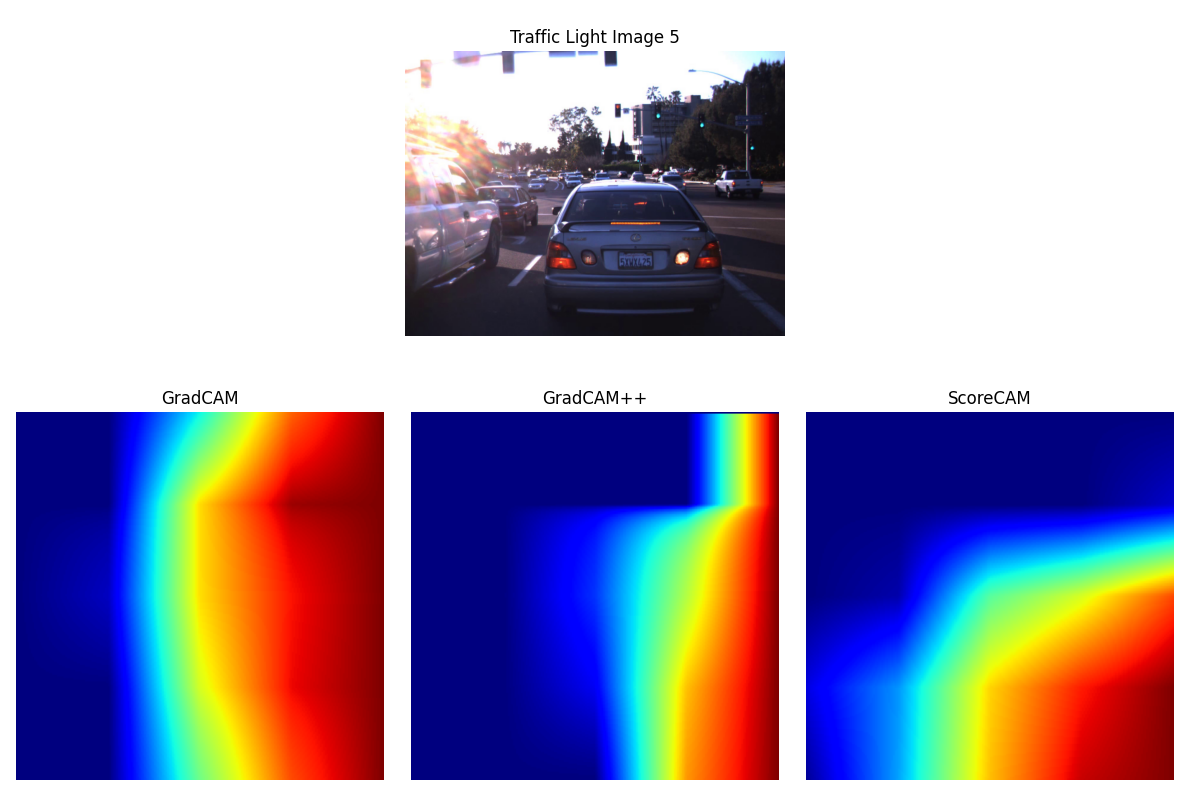

Prediction: stop
True Label: go


In [38]:
# pull data for image 5
imgs, labels = next(iter(val_flow))
img = imgs[0:1]

cam, cam_pp, cam_sc, prediction = gradCAM_variation(img, model)

# get image
i = i+1
img_no = i+1
clip_str = val_df.reset_index(drop=True).loc[i]['Filename']
true = val_df.reset_index(drop=True).loc[i]['Annotation tag']
img_path = os.path.join(path, 'dayTrain', 'dayTrain', 'dayClip1', 'frames',
                        clip_str)
img_im = mpimg.imread(img_path)

plot_img_heatmaps(cam, cam_pp, cam_sc, img_im, img_no)

print(f"Prediction: {prediction}")
print(f"True Label: {true}")